In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn import datasets
from nilearn.plotting import plot_stat_map
from scipy import stats

from dd_kable_analysis.config_loader import load_config

# Analysis methods (for reference)
We performed subject-level, ROI-wise multivoxel prediction of the larger-later reward amount from trialwise beta-series patterns using a nested, run-wise cross-validation framework. For each subject, trial regressors were identified from the design matrix (trial_type matching ^trial) and linked to beta-series effect-size images; trials were excluded if flagged for high collinearity (VIF > 5) or if the corresponding beta image was missing. Subjects were required to have at least 3 usable runs, and runs were required to retain ≥20 trials after omissions (runs failing this threshold were dropped if ≥3 usable runs remained, otherwise the subject was excluded). Features were extracted by applying a fixed group mask to all beta images to obtain a consistent voxel ordering, then restricting to voxels within each atlas-defined ROI (minimum ROI size: 50 voxels). Additional run-aware voxel QC removed voxels that were near-zero (|beta| < 1e−4) on more than 5% of trials in any run (criterion required to hold across all runs), and ROIs were skipped if <50 voxels remained after QC. Within each retained ROI, we fit ridge regression models to predict amount using nested GroupKFold cross-validation grouped by run: the outer loop implemented leave-one-run-out to generate out-of-sample predictions for all trials, and the inner loop (leave-one-run-out within the training runs) selected the ridge penalty $\alpha$ by minimizing mean squared error over a log-spaced grid ($\alpha = 10^{\mathrm{linspace}(-2,6,20)}$). Feature standardization was performed within each training fold via a StandardScaler inside the ridge pipeline. Performance was summarized using correlation between true and out-of-sample predicted values and a fold-safe cross-validated $R^2$ computed relative to a training-mean baseline within each outer fold.

# What is this notebook showing?

### Prediction for each ROI
Here I aggregate the results from the ROI-based MVPA analyses across all subjects. For each ROI I compute the mean of multiple measures of prediction quality (Fisher's Z, cor(y, y-hat), r-squared, RMSE) across subjects.  I also show the mean alpha, where large values indicate poor predictive quality in this case.

### Voxel retention by ROI
This section has a histogram for each ROI showing the ratio of usable voxels to total voxels for each ROI across subjects.  The code sets a rule that at least 50 voxels must be usable.

### Inspect variability of predicted values
When `alpha` is large, the regularization sets all feature weights to 0, implying the prediction is only reflecting the mean of the training data for all trials in the test set.  To check whether this is the case we can compare the sd(y) to sd(y-hat).  This section performs this comparison and a figure shows the ratio is generally close to 0.

### Exploring error by Delay amount
We wondered if the lack of predictive ability found in previous steps was because the predictions were varying by the delay and the overall prediction was a wash since it averages over delay levels.  In this section I explored whether he error related to the delay  and found a very small negative correlation (as delay increased the error decreased, around -0.01).  Since the classifier seemed to be reducing itself to predicting the mean, I estimated a "baseline" prediction model (prediction amount for a given run is the average of the amount of the other runs) and related the error of this baseline prediction model to delay.  The results were similar to the actual model.  Further, I looked at the difference in errors between these two models and related it to delay and no relationship was found, indicating that there isn't an improvment in error between the ridge model and baseline model as delay changes.

### Overall conclusions
For the ROI set tested, cross-validated ridge models did not decode LL amount above a training-mean baseline: out-of-sample predictions largely collapsed toward the mean, yielding near-zero/negative $r$ and $R^2_{cv}$. Using a baseline-relative error metric ($\Delta SE = SE_{\text{model}} - SE_{\text{baseline}}$) computed out-of-sample, we also found no evidence that decoding performance systematically varied with delay (the subject-level $\mathrm{corr}(\Delta SE,\ \log(\mathrm{Delay}))$ distributions were centered near zero across ROIs).

In [2]:
cfg = load_config()

OUT_ROOT = Path(cfg.output_root) / 'mvpa_josh_rois'
atlas_path = Path(cfg.masks_dir) / 'josh_orig_rois.nii.gz'


## Prediction for each ROI

Below the table shows the mean Fisher's Z (mean r, mean r-squared and mean rmse) for each ROI, averaged across 111 subejcts. 

Conclusions:
The prediction is poor (negative Fisher's Z, etc) and alpha is very large which indicates poor predictive ability.

In [3]:
# 0) Get ROI mask labels
mask_dir = Path(cfg.masks_dir)
labels_path = mask_dir / 'josh_orig_rois_labels.txt'

# read the labels txt (tab-delimited; comment line starts with #)
roi_labels = pd.read_csv(labels_path, sep=r'\s+', comment='#', header=None)
roi_labels.columns = ['roi_label', 'roi_name', 'mask_file']
roi_labels['roi_label'] = roi_labels['roi_label'].astype(int)

# 1) Load all roi_summary.csv and merge with ROI labels
files = sorted(OUT_ROOT.glob('sub-*/roi_summary.csv'))
all_roi = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
# merge (keep only roi_name from the labels table)
all_roi = all_roi.merge(
    roi_labels[['roi_label', 'roi_name']], on='roi_label', how='left'
)


# 2) Group mean Fisher-z by roi_label
roi_grp = all_roi.groupby('roi_name', as_index=False).agg(
    roi_label=('roi_label', 'first'),
    n_subs=('sub_id', 'nunique'),
    mean_fisher_z=('fisher_z', 'mean'),
    mean_r=('r', 'mean'),
    mean_r2_cv=('r2_cv', 'mean'),
    mean_rmse=('rmse', 'mean'),
    mean_alpha=('mean_alpha', 'mean'),
)

roi_grp

,roi_name,roi_label,n_subs,mean_fisher_z,mean_r,mean_r2_cv,mean_rmse,mean_alpha
0,L_Caudate,1,111,-0.065100,-0.064650,-0.009024,19.176823,549031.075841
1,L_NACC,3,111,-0.064077,-0.063451,-0.017246,19.252187,466269.553021
2,OFCmed_L,7,111,-0.059320,-0.058938,-0.010872,19.193086,500954.466637
3,OFCmed_R,8,111,-0.073292,-0.072603,-0.015296,19.235920,484888.509024
4,Precentral_L,5,111,-0.051425,-0.051191,-0.008365,19.170249,497959.769274
5,Precentral_R,6,111,-0.062239,-0.061566,-0.015563,19.232880,542727.573499
6,R_Caudate,2,111,-0.070472,-0.070148,-0.011206,19.196668,522662.452611
7,R_NACC,4,111,-0.061949,-0.061656,-0.020178,19.273297,493321.112731


In [4]:
all_roi

,sub_id,roi_label,n_trials,n_runs,n_vox_preQC,n_vox_postQC,r,r2_cv,fisher_z,rmse,mean_alpha,roi_name
0,dmp0011,1,116,4,2383,2310,-0.161865,-0.015567,-0.163302,19.551916,755172.845203,L_Caudate
1,dmp0011,2,116,4,1355,1304,-0.173996,-0.019538,-0.175784,19.590105,751961.899926,R_Caudate
2,dmp0011,3,116,4,532,512,-0.131062,-0.026264,-0.131820,19.654613,750744.087860,L_NACC
3,dmp0011,4,116,4,867,841,-0.157936,-0.016482,-0.159269,19.560720,503923.799852,R_NACC
4,dmp0011,5,116,4,3017,2994,-0.158518,-0.005273,-0.159867,19.452568,527277.973906,Precentral_L
...,...,...,...,...,...,...,...,...,...,...,...,...
883,dmp1291,4,115,4,867,846,-0.240196,-0.019842,-0.244982,19.617710,750744.087860,R_NACC
884,dmp1291,5,115,4,3017,3001,-0.207010,-0.024153,-0.210045,19.659129,755172.845203,Precentral_L
885,dmp1291,6,115,4,2495,2470,-0.258359,-0.009899,-0.264349,19.521837,763638.986953,Precentral_R
886,dmp1291,7,115,4,573,507,-0.236281,-0.012709,-0.240832,19.548982,750744.087860,OFCmed_L


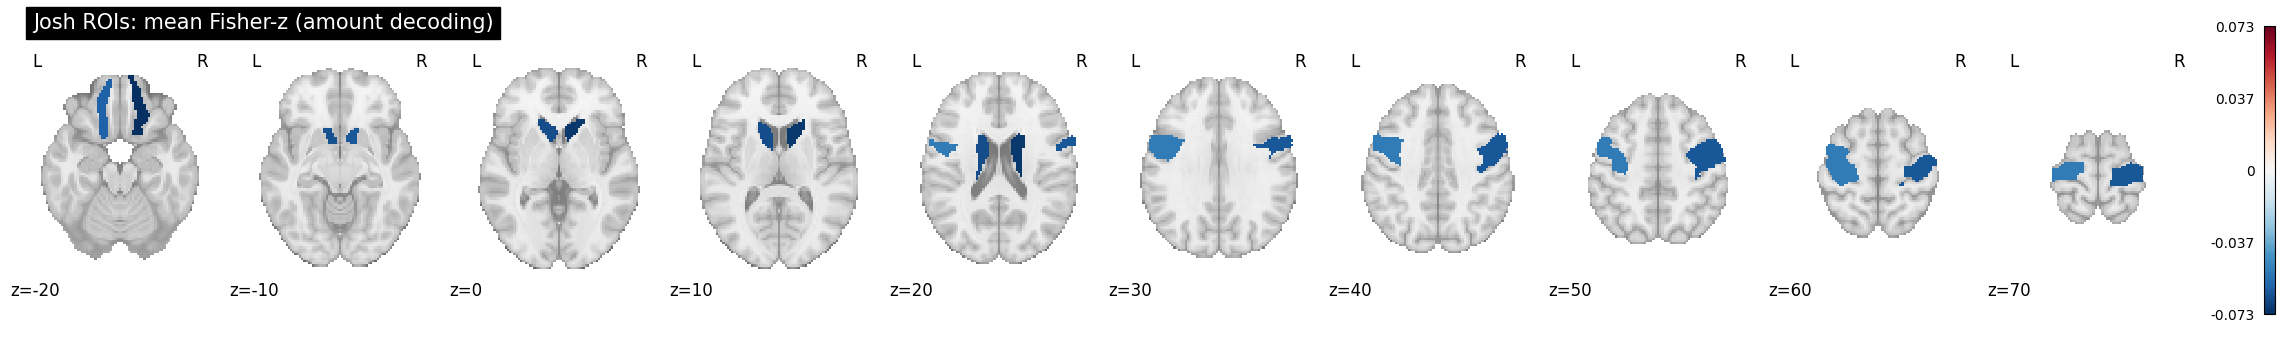

In [5]:
atlas_img = nib.load(str(atlas_path))
atlas = atlas_img.get_fdata().astype(int)

# map ROI label -> value
val_map = dict(
    zip(roi_grp['roi_label'].astype(int), roi_grp['mean_fisher_z'].astype(float))
)

stat = np.zeros_like(atlas, dtype=np.float32)
for lab, val in val_map.items():
    stat[atlas == lab] = np.float32(val)

img_meanz = nib.Nifti1Image(stat, atlas_img.affine, atlas_img.header)

# Plot (diverging: blue negative, warm positive)
plot_stat_map(
    img_meanz,
    title='Josh ROIs: mean Fisher-z (amount decoding)',
    display_mode='z',
    cut_coords=np.arange(-20, 71, 10),
    symmetric_cbar=True,
)

## Voxel retention by ROI

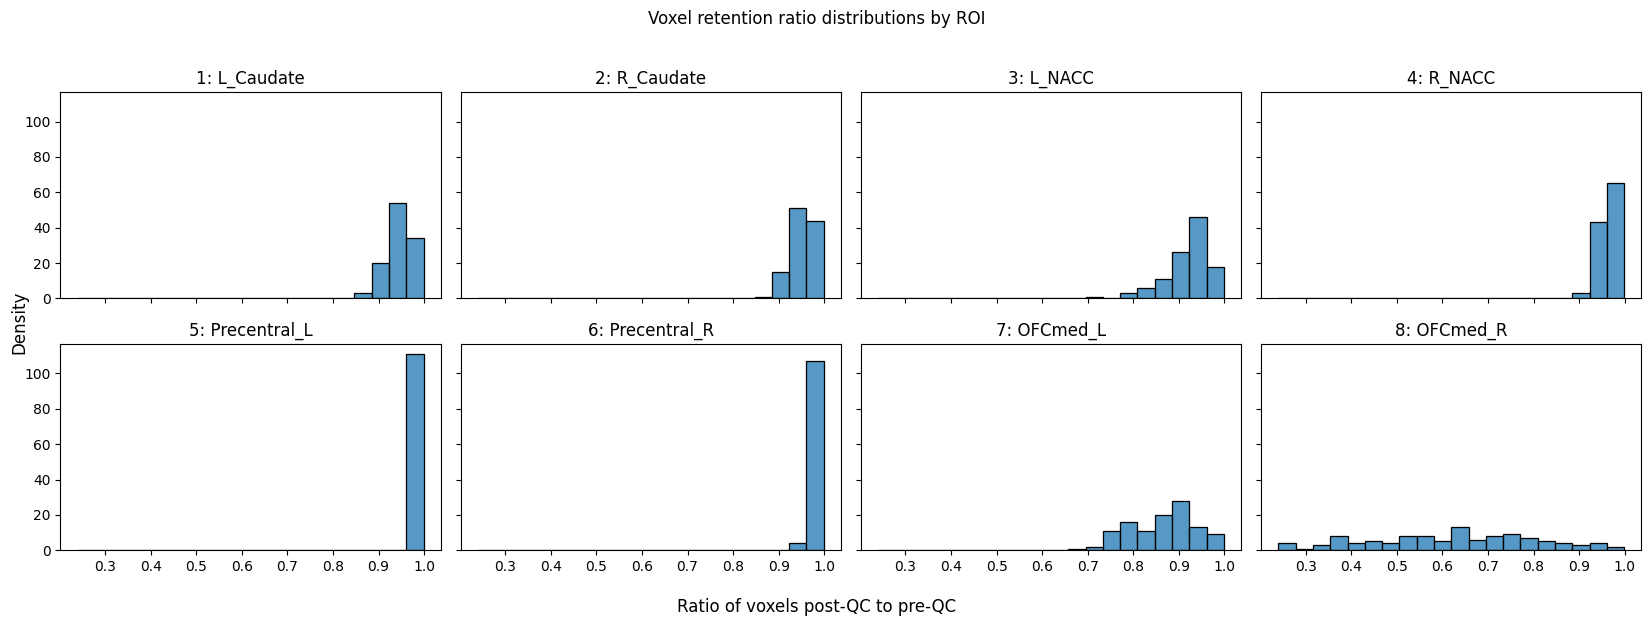

In [6]:
# Check how good the ROI coverage is across subjects for each ROI
# ratio of voxels in ROI that were usable for each subject
all_roi = all_roi.copy()
all_roi['ratio_nvox_postQC_nvox_preQC'] = (
    all_roi['n_vox_postQC'] / all_roi['n_vox_preQC']
)

rois = all_roi[['roi_label', 'roi_name']].drop_duplicates().sort_values('roi_label')

n_rois = len(rois)
ncols = 4
nrows = int(np.ceil(n_rois / ncols))

fig, axes = plt.subplots(
    nrows, ncols, figsize=(4.2 * ncols, 3.0 * nrows), sharex=True, sharey=True
)
axes = np.atleast_1d(axes).ravel()

# choose common bins so panels are comparable
x = all_roi['ratio_nvox_postQC_nvox_preQC'].dropna().to_numpy()
bins = np.linspace(np.min(x), np.max(x), 21)  # 20 bins

for ax, (_, row) in zip(axes, rois.iterrows()):
    lab = int(row['roi_label'])
    name = str(row['roi_name'])

    d = all_roi.loc[
        all_roi['roi_label'] == lab, 'ratio_nvox_postQC_nvox_preQC'
    ].dropna()
    sns.histplot(d, bins=bins, ax=ax)
    ax.set_title(f'{lab}: {name}')
    ax.set_xlabel('')
    ax.set_ylabel('')

# turn off unused axes
for ax in axes[len(rois) :]:
    ax.axis('off')

fig.supxlabel('Ratio of voxels post-QC to pre-QC')
fig.supylabel('Density')
fig.suptitle('Voxel retention ratio distributions by ROI', y=1.02)
plt.tight_layout()
plt.show()

## Inspect variability of predicted values

### Check prediction quality (does the model do more than predict the mean?)
A common failure mode in ridge decoding is that cross-validation selects a very large regularization parameter (`alpha`). When `alpha` is large, the ridge weights shrink toward zero and the model’s predictions collapse toward the training mean of y. In that case, the model produces nearly constant predictions and decoding performance will be near chance.

To diagnose this, we compare:
* `y_std` = standard deviation of the true target values (y) across trials
* `yhat_std` = standard deviation of the out-of-sample predictions (ŷ) across trials

If the model is capturing meaningful trial-to-trial variation, `yhat_std` should be on a similar scale to `y_std`. If the model is mostly predicting the mean, `yhat_std` will be much smaller than `y_std`.

We summarize this with:
* `std_ratio` = `yhat_std` / `y_std`

Interpretation:
* `std_ratio` ≈ 1: predictions vary appropriately (consistent with informative decoding)
* `std_ratio` ≪ 1: predictions are overly “flat” (consistent with mean-prediction / poor decoding)

In [7]:
def corr_np(a, b):
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    if len(a) < 3:
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])


tw_files = sorted(OUT_ROOT.glob('sub-*/trialwise_preds.csv'))
tw_all = pd.concat([pd.read_csv(f) for f in tw_files], ignore_index=True)
# add the ROi names
tw_all = tw_all.merge(roi_labels[['roi_label', 'roi_name']], on='roi_label', how='left')


# make sure keys have consistent dtypes
df = tw_all[['sub_id', 'roi_label', 'y', 'yhat_oos']].copy()
df['sub_id'] = df['sub_id'].astype(str)
df['roi_label'] = pd.to_numeric(df['roi_label'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['yhat_oos'] = pd.to_numeric(df['yhat_oos'], errors='coerce')
df = df.dropna(subset=['roi_label', 'y', 'yhat_oos'])
df['roi_label'] = df['roi_label'].astype(int)

# summary stds
by_sub_roi = df.groupby(['sub_id', 'roi_label'], as_index=False).agg(
    y_std=('y', lambda s: float(np.std(s, ddof=1))),
    yhat_std=('yhat_oos', lambda s: float(np.std(s, ddof=1))),
)

# correlations (may warn depending on pandas version; remove include_groups if it errors)
r_df = (
    df.groupby(['sub_id', 'roi_label'], as_index=False)
    .apply(
        lambda d: pd.Series({'r_trialwise': corr_np(d['y'], d['yhat_oos'])}),
        include_groups=False,
    )
    .reset_index(drop=True)
)
r_df = r_df.merge(roi_labels[['roi_label', 'roi_name']], on='roi_label', how='left')


by_sub_roi = by_sub_roi.merge(r_df, on=['sub_id', 'roi_label'], how='left')
by_sub_roi['std_ratio'] = by_sub_roi['yhat_std'] / by_sub_roi['y_std']


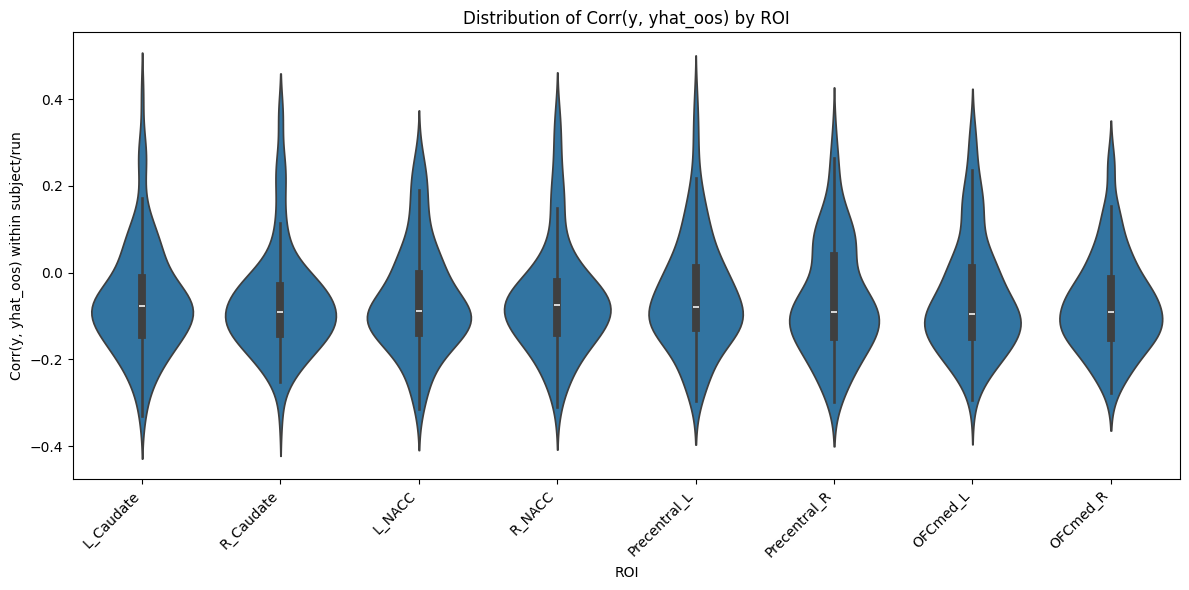

In [8]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=by_sub_roi, x='roi_name', y='r_trialwise')
plt.xticks(rotation=45, ha='right')
plt.xlabel('ROI')
plt.ylabel('Corr(y, yhat_oos) within subject/run')
plt.title('Distribution of Corr(y, yhat_oos) by ROI')
plt.tight_layout()
plt.show()

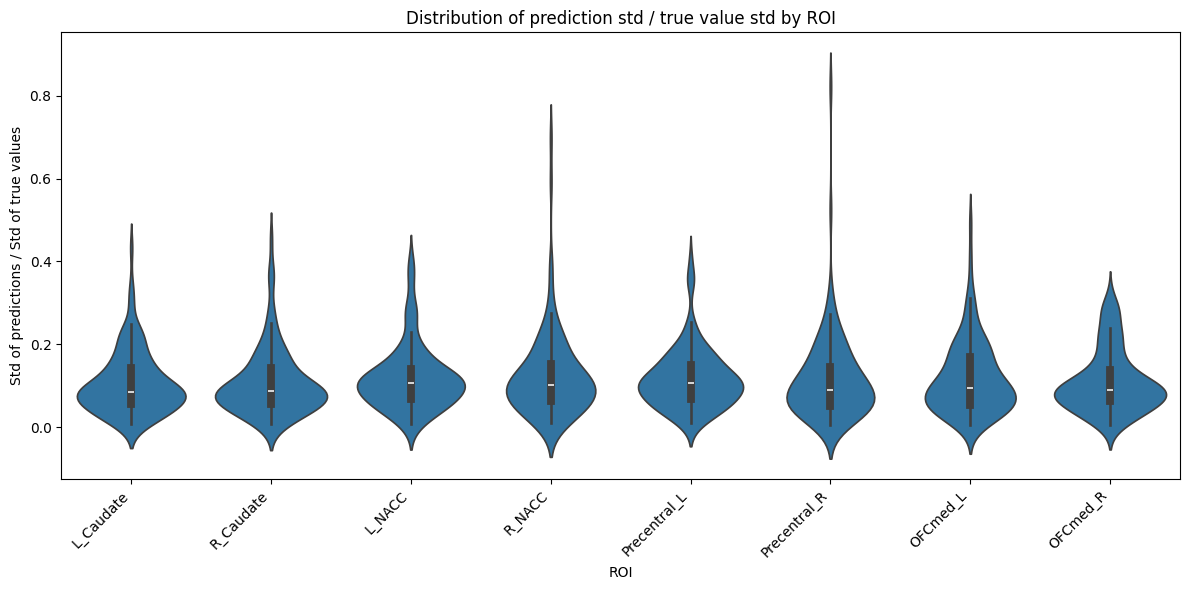

In [9]:
# seaborn violin plot of std_ratio by roi_name
plt.figure(figsize=(12, 6))
sns.violinplot(data=by_sub_roi, x='roi_name', y='std_ratio')
plt.xticks(rotation=45, ha='right')
plt.xlabel('ROI')
plt.ylabel('Std of predictions / Std of true values')
plt.title('Distribution of prediction std / true value std by ROI')
plt.tight_layout()
plt.show()

## Exploring error by Delay amount

* What do the predictions look like 
    * They are tightly clustered around the mean of the true Amount (roughly 50) and have very low variability
* Is amount related to delay?
    * no
* Does variability of amount differ by binned delay values
    * a little
* How does the error of the baseline model (prediction is the mean of the training data amounts) relate to delay?  
    * The relationship is similar to the Ridge model we ran
    * The difference in errors between our model and baseline model does not relate to delay


Conclusion: The low prediction found above isn't because it is averaged over levels of delay.

**What do the predictions looks like compared to the true amounts?**

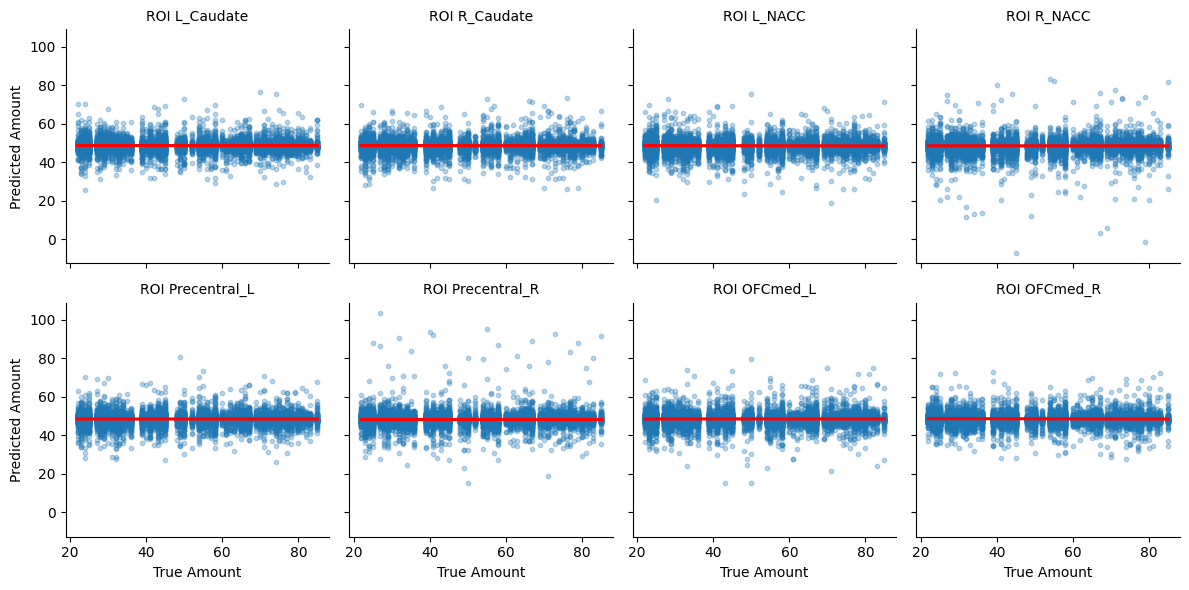

In [10]:
g = sns.lmplot(
    data=tw_all,
    x='y',
    y='yhat_oos',
    col='roi_name',
    col_wrap=4,
    scatter_kws={'alpha': 0.3, 's': 10},
    line_kws={'color': 'red'},
    height=3,
)

g.set_axis_labels('True Amount', 'Predicted Amount')
g.set_titles('ROI {col_name}')

plt.tight_layout()
plt.show()

**Is amount related to the delay or does the amount variability change by delay**

Equally spaced delay bins are used here since delay is fairly uniform.

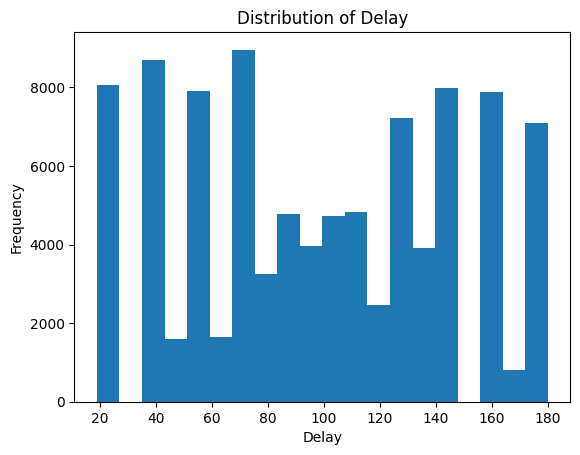

In [11]:
# First check the distribution of delay (mostly normal-ish)

plt.hist(tw_all['Delay'].dropna(), bins=20)
plt.xlabel('Delay')
plt.ylabel('Frequency')
plt.title('Distribution of Delay')
plt.show()

Summary of within-run correlations between amount and delay:
count    416.000000
mean       0.006351
std        0.169234
min       -0.434918
25%       -0.106901
50%        0.028782
75%        0.130435
max        0.346479
Name: corr_amount_delay, dtype: float64


/tmp/ipykernel_16229/1796033639.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d['amount'].corr(d['Delay']))


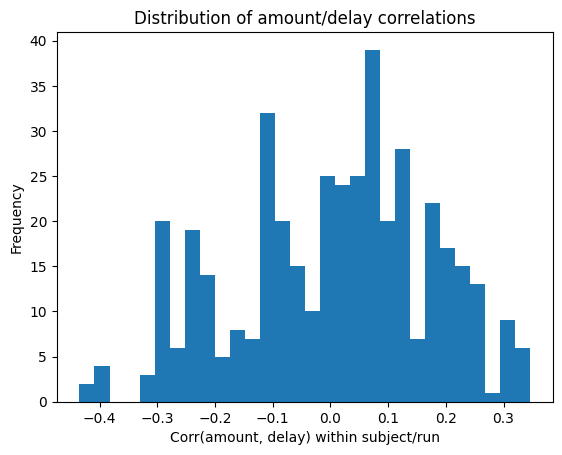

In [12]:
# There does not appear to be a relationship between amount and delay across the dataset.

# --- Correlation within each subject/run ---
corr_df = (
    tw_all.groupby(['sub_id', 'run'])
    .apply(lambda d: d['amount'].corr(d['Delay']))
    .reset_index(name='corr_amount_delay')
)

print('Summary of within-run correlations between amount and delay:')
print(corr_df['corr_amount_delay'].describe())

# --- Histogram of correlations ---
plt.figure()
plt.hist(corr_df['corr_amount_delay'].dropna(), bins=30)
plt.xlabel('Corr(amount, delay) within subject/run')
plt.ylabel('Frequency')
plt.title('Distribution of amount/delay correlations')
plt.show()

**Checking the variance of amount across levels of delay**

There are some small changes in variability.

Summary of variance of amount within delay bins:
                 count        mean         std        min         25%  \
delay_interval                                                          
(18.839, 59.25]  416.0  311.627671  111.021745  67.205674  226.266010   
(59.25, 99.5]    416.0  355.791473  112.346220  16.193548  313.571429   
(99.5, 139.75]   416.0  340.128325  134.293369  28.471795  245.588652   
(139.75, 180.0]  416.0  265.616886  106.605780   0.000000  201.189744   

                        50%         75%         max  
delay_interval                                       
(18.839, 59.25]  308.790677  394.893617  634.000000  
(59.25, 99.5]    366.412698  410.920635  630.492754  
(99.5, 139.75]   361.333333  424.457143  874.580645  
(139.75, 180.0]  282.582278  346.523810  558.194872  


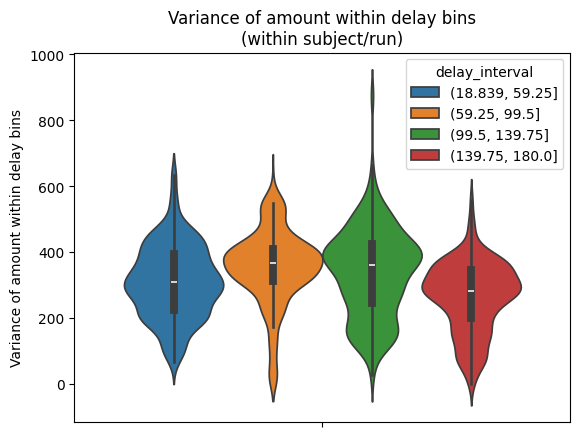

In [13]:
# Does the variance of amount vary by delay bins?

tw_binned = tw_all.copy()

# Create global bins (edges determined using ALL data)
global_bins = pd.cut(tw_binned['Delay'], bins=4)

# Extract the actual bin edges
bin_edges = global_bins.cat.categories

# Now apply those SAME edges to everyone
tw_binned['delay_interval'] = pd.cut(
    tw_binned['Delay'],
    bins=[interval.left for interval in bin_edges] + [bin_edges[-1].right],
)

# Integer bin index (0–3)
tw_binned['delay_bin'] = pd.factorize(tw_binned['delay_interval'])[0]

# String label
tw_binned['delay_bin_range'] = tw_binned['delay_interval'].astype(str)

var_within_bins = (
    tw_binned.groupby(['sub_id', 'run', 'delay_interval'], observed=True)['amount']
    .var()
    .reset_index(name='var_amount_within_bin')
)

# Print distribution of variances within bins for each delay_interval value
print('Summary of variance of amount within delay bins:')
print(
    var_within_bins.groupby('delay_interval', observed=True)[
        'var_amount_within_bin'
    ].describe()
)
# --- Violin plot ---
plt.figure()
sns.violinplot(
    y='var_amount_within_bin',
    inner='box',
    hue='delay_interval',
    data=var_within_bins,
)
plt.ylabel('Variance of amount within delay bins')
plt.title('Variance of amount within delay bins\n(within subject/run)')
plt.show()

**Check if the error relates to delay at all**

In [14]:
tw_all_cp = tw_all.copy()

# basic cleanup
tw_all_cp = tw_all_cp.dropna(subset=['y', 'yhat_oos', 'Delay'])
tw_all_cp['Delay'] = pd.to_numeric(tw_all_cp['Delay'])
tw_all_cp['y'] = pd.to_numeric(tw_all_cp['y'])
tw_all_cp['yhat_oos'] = pd.to_numeric(tw_all_cp['yhat_oos'])

# error metrics
tw_all_cp['se'] = (tw_all_cp['y'] - tw_all_cp['yhat_oos']) ** 2
tw_all_cp['ae'] = (tw_all_cp['y'] - tw_all_cp['yhat_oos']).abs()
tw_all_cp['logDelay'] = np.log1p(tw_all_cp['Delay'])

# Correlation with se
corr_se = (
    tw_all_cp.groupby(['sub_id', 'roi_name'], observed=True)
    .apply(lambda d: d['logDelay'].corr(d['se']))
    .reset_index(name='corr_logDelay_se')
)

# Correlation with ae
corr_ae = (
    tw_all_cp.groupby(['sub_id', 'roi_name'], observed=True)
    .apply(lambda d: d['logDelay'].corr(d['ae']))
    .reset_index(name='corr_logDelay_ae')
)

/tmp/ipykernel_16229/667777088.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d['logDelay'].corr(d['se']))
/tmp/ipykernel_16229/667777088.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d['logDelay'].corr(d['ae']))


In [15]:
print('Summary of within-run correlations between logDelay and SE:')
print(corr_se.groupby('roi_name', observed=True)['corr_logDelay_se'].describe())

print('Summary of within-run correlations between logDelay and AE:')
print(corr_ae.groupby('roi_name', observed=True)['corr_logDelay_ae'].describe())

Summary of within-run correlations between logDelay and SE:
              count      mean       std       min       25%       50%  \
roi_name                                                                
L_Caudate     111.0 -0.012826  0.043127 -0.201252 -0.033411 -0.009565   
L_NACC        111.0 -0.011219  0.042122 -0.206276 -0.030036 -0.011855   
OFCmed_L      111.0 -0.008411  0.043921 -0.218385 -0.026927 -0.010545   
OFCmed_R      111.0 -0.012118  0.042954 -0.186771 -0.028696 -0.014609   
Precentral_L  111.0 -0.013448  0.041500 -0.189395 -0.032456 -0.013818   
Precentral_R  111.0 -0.012729  0.040907 -0.211636 -0.026720 -0.011660   
R_Caudate     111.0 -0.014890  0.045809 -0.202163 -0.030756 -0.013339   
R_NACC        111.0 -0.010542  0.042570 -0.193325 -0.030727 -0.009780   

                   75%       max  
roi_name                          
L_Caudate     0.010897  0.118542  
L_NACC        0.009909  0.117903  
OFCmed_L      0.014097  0.103139  
OFCmed_R      0.011696  0.172331  

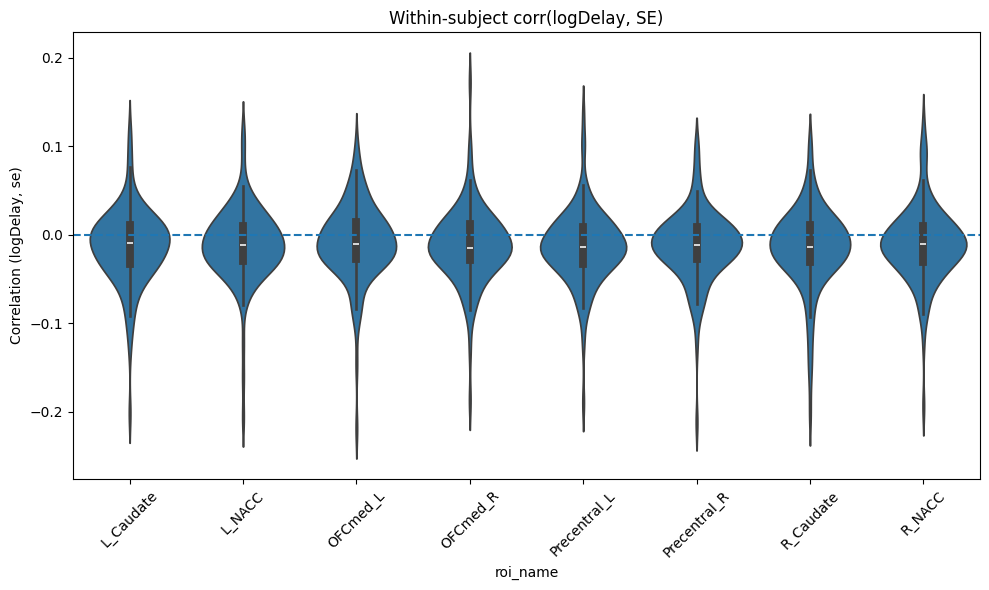

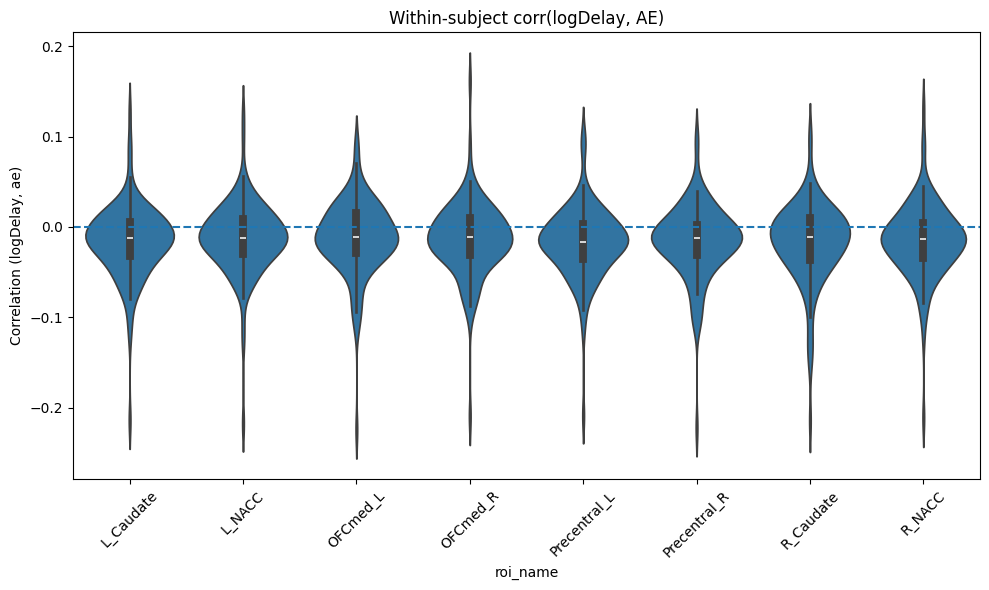

In [16]:
plt.figure(figsize=(10, 6))

sns.violinplot(data=corr_se, x='roi_name', y='corr_logDelay_se', inner='box')

plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Correlation (logDelay, se)')
plt.title('Within-subject corr(logDelay, SE)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

sns.violinplot(data=corr_ae, x='roi_name', y='corr_logDelay_ae', inner='box')

plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Correlation (logDelay, ae)')
plt.title('Within-subject corr(logDelay, AE)')
plt.tight_layout()
plt.show()

**I'm not sure I trust the above, so this is a check**

On average, there's a very small negative correlation for all ROIs between the prediction error and delay (the larger the delay the smaller the prediction error).  These correlations are around -0.01, so not very impressive.

Since it appears the prediction is often simply using the mean of the training values of amount as the predicted amounts, I can form a test.  Here I will run this exact "prediction" to see if I get a similar correlation between "predicition" error and delay.  If it doesn't pan out, then perhaps this tiny correlation is driven by meaningful variability?  I'll know more when I repeat this across all of the Schaefer ROIs, since a correlation across all of those ROIs would likely reflect artifact (I just haven't rerun it yet).

In [17]:
# To avoid loops we first calculate the sum across all trials (all runs) then within-run
# We also track the total number of trials overall and within run
# Then the run-specific prediction is the (total sum - within-run sum) / (total n - within-run n)

df = tw_all.copy()

# totals per subject×ROI
tot = (
    df.groupby(['sub_id', 'roi_name'])['amount']
    .agg(sum_amount_all_runs='sum', n_all='size')
    .reset_index()
)

# per-run sums per subject×ROI×run
byrun = (
    df.groupby(['sub_id', 'roi_name', 'run'])['amount']
    .agg(sum_amount_run='sum', n_run='size')
    .reset_index()
)

# compute leave-one-run-out training mean
byrun = byrun.merge(tot, on=['sub_id', 'roi_name'], how='left')
byrun['sum_train'] = byrun['sum_amount_all_runs'] - byrun['sum_amount_run']
byrun['n_train'] = byrun['n_all'] - byrun['n_run']
byrun['yhat_base_oos'] = byrun['sum_train'] / byrun['n_train'].replace(0, np.nan)

# merge baseline prediction back into each trial row
df = df.merge(
    byrun[['sub_id', 'roi_name', 'run', 'yhat_base_oos']],
    on=['sub_id', 'roi_name', 'run'],
    how='left',
    validate='many_to_one',
)

# errors
df['se_model'] = (df['amount'] - df['yhat_oos']) ** 2
df['se_base'] = (df['amount'] - df['yhat_base_oos']) ** 2
df['delta_se'] = df['se_model'] - df['se_base']

# log delay
df['logDelay'] = np.log1p(df['Delay'])

In [18]:
# Repeat (even though we did this above)
corr_se_model = (
    df.groupby(['sub_id', 'roi_name'], observed=True)[['logDelay', 'se_model']]
    .corr()
    .unstack()
    .iloc[:, 1]  # correlation of logDelay with se_model
    .reset_index(name='corr_logDelay_se_model')
)

corr_se_base = (
    df.groupby(['sub_id', 'roi_name'], observed=True)[['logDelay', 'se_base']]
    .corr()
    .unstack()
    .iloc[:, 1]
    .reset_index(name='corr_logDelay_se_base')
)

In [19]:
print('Summary of correlations between logDelay and SE from the model:')
print(
    corr_se_model.groupby('roi_name', observed=True)[
        'corr_logDelay_se_model'
    ].describe()
)

print('Summary of correlations between logDelay and SE from the baseline:')
print(
    corr_se_base.groupby('roi_name', observed=True)['corr_logDelay_se_base'].describe()
)


Summary of correlations between logDelay and SE from the model:
              count      mean       std       min       25%       50%  \
roi_name                                                                
L_Caudate     111.0 -0.012826  0.043127 -0.201252 -0.033411 -0.009565   
L_NACC        111.0 -0.011219  0.042122 -0.206276 -0.030036 -0.011855   
OFCmed_L      111.0 -0.008411  0.043921 -0.218385 -0.026927 -0.010545   
OFCmed_R      111.0 -0.012118  0.042954 -0.186771 -0.028696 -0.014609   
Precentral_L  111.0 -0.013448  0.041500 -0.189395 -0.032456 -0.013818   
Precentral_R  111.0 -0.012729  0.040907 -0.211636 -0.026720 -0.011660   
R_Caudate     111.0 -0.014890  0.045809 -0.202163 -0.030756 -0.013339   
R_NACC        111.0 -0.010542  0.042570 -0.193325 -0.030727 -0.009780   

                   75%       max  
roi_name                          
L_Caudate     0.010897  0.118542  
L_NACC        0.009909  0.117903  
OFCmed_L      0.014097  0.103139  
OFCmed_R      0.011696  0.1723

**Last, does the change in se (model vs baseline) relate to logDelay?**

The above shows the correlations between se's and logDelay are similar, but this directly tests whether there is a relationship between the two prediction error differences and logDelay.  If the model was showing an improved prediction above the mean that varied by Delay, this would capture that.  Unfortunately no relationship is found.

In [20]:
# check whether the difference in se (model vs baseline) is related to logDelay

corr_delta_se = (
    df.groupby(['sub_id', 'roi_name'], observed=True)[['logDelay', 'delta_se']]
    .corr()
    .unstack()
    .iloc[:, 1]
    .reset_index(name='corr_logDelay_delta_se')
)

print(
    'Summary of correlations between logDelay and the difference in SE (model vs baseline):'
)
print(
    corr_delta_se.groupby('roi_name', observed=True)[
        'corr_logDelay_delta_se'
    ].describe()
)

Summary of correlations between logDelay and the difference in SE (model vs baseline):
              count      mean       std       min       25%       50%  \
roi_name                                                                
L_Caudate     111.0 -0.001859  0.093854 -0.220945 -0.074743 -0.008377   
L_NACC        111.0 -0.000992  0.090437 -0.223905 -0.059664  0.004150   
OFCmed_L      111.0  0.012973  0.090257 -0.185857 -0.045977  0.018122   
OFCmed_R      111.0  0.007492  0.094561 -0.265952 -0.055801  0.004721   
Precentral_L  111.0 -0.004361  0.086473 -0.268607 -0.055590 -0.001082   
Precentral_R  111.0  0.002123  0.095425 -0.204120 -0.055925  0.003289   
R_Caudate     111.0 -0.002616  0.092535 -0.272558 -0.052411  0.001020   
R_NACC        111.0  0.001821  0.088990 -0.219715 -0.056416 -0.002325   

                   75%       max  
roi_name                          
L_Caudate     0.073885  0.231210  
L_NACC        0.057862  0.215561  
OFCmed_L      0.069229  0.246873  
OFCmed_

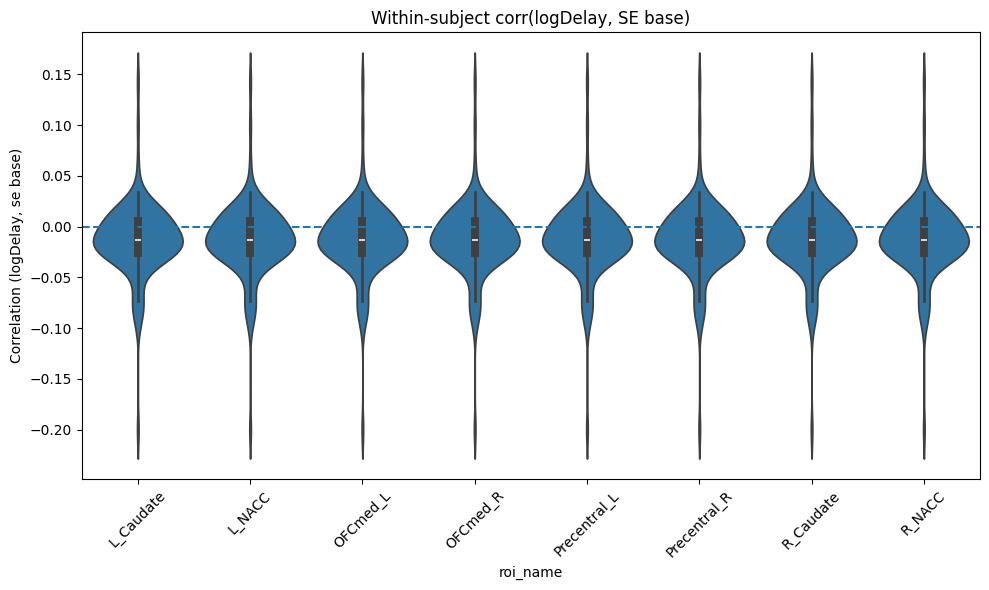

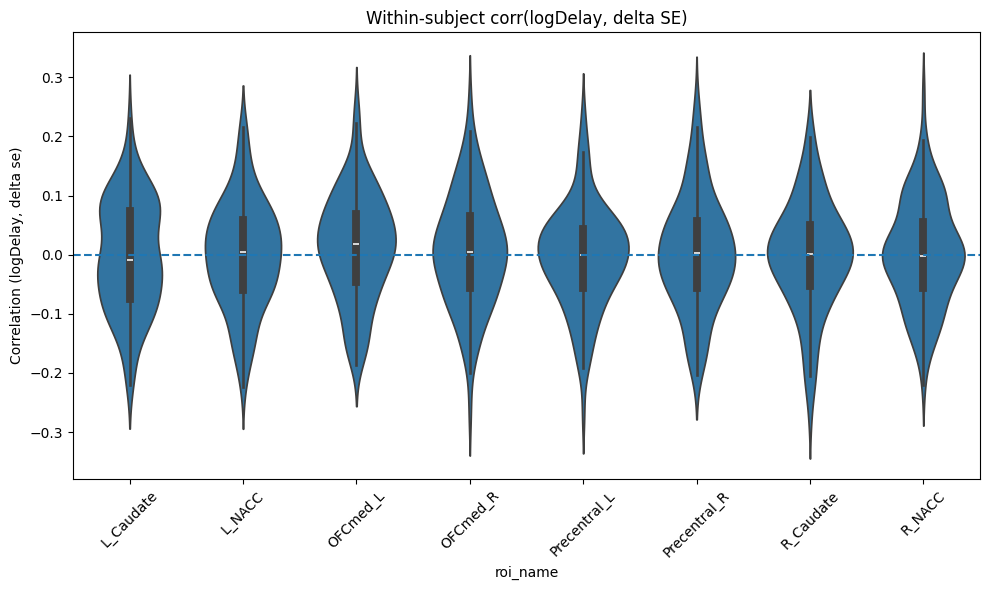

In [21]:
plt.figure(figsize=(10, 6))

sns.violinplot(data=corr_se_base, x='roi_name', y='corr_logDelay_se_base', inner='box')

plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Correlation (logDelay, se base)')
plt.title('Within-subject corr(logDelay, SE base)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

sns.violinplot(
    data=corr_delta_se, x='roi_name', y='corr_logDelay_delta_se', inner='box'
)

plt.axhline(0, linestyle='--')
plt.xticks(rotation=45)
plt.ylabel('Correlation (logDelay, delta se)')
plt.title('Within-subject corr(logDelay, delta SE)')
plt.tight_layout()
plt.show()